# 2023-09-13 · Clippin and Ceilin

In [1]:
include("lib/Nto1.jl")

using Revise … ✔ (0.3 s)
using Units, Nto1AdEx, ConnectionTests, ConnTestEval … ✔ (0.1 s)
using StatsBase … ✔ (0.2 s)


In [7]:
N = 6500
duration = 10minutes

@time sim = Nto1AdEx.sim(N, duration, ceil_spikes = false);

  1.896686 seconds (28.10 k allocations: 912.671 MiB, 6.85% gc time, 0.42% compilation time)


(Hm, spikerate not 4.0 Hz (even though we use our lookup table))

In [6]:
sim.spikerate / Hz

4.7

## Ceil

In [9]:
V_no_ceil = sim.V;
V_ceil = ceil_spikes!(copy(V_no_ceil), sim.spiketimes);  # V_ceil = Vₛ = 
Nto1AdEx.Vₛ / mV

40

In [10]:
include("lib/plot.jl")

import PythonCall … ✔ (1.9 s)
import PythonPlot … ✔ (3.8 s)
using Sciplotlib … ✔ (0.5 s)
using PhDPlots … ✔


In [22]:
default_figsize

(4, 2.4)

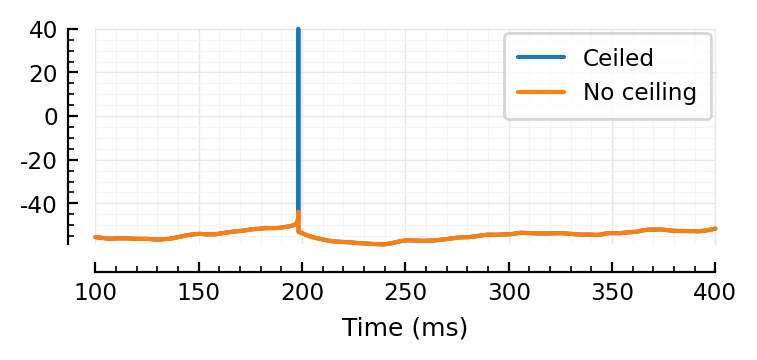

In [24]:
fig, ax = plt.subplots(figsize=(4, 1.4))
plotsig(V_ceil / mV,    [100, 400], ms, label="Ceiled")
plotsig(V_no_ceil / mV, [100, 400], ms, label="No ceiling")
legend(ax, reverse=false);

## Clip

And now for the clipping, we do it data driven (i.e. no spike detection), just a percentile.

In [26]:
include("lib/df.jl")

using DataFrames … ✔ (0.8 s)


In [43]:
set_print_precision(4)
ENV["DATAFRAMES_ROWS"] = 11;

In [45]:
ps = [0, 0.1, 1, 5, 10, 50, 90, 99, 95, 99.9, 99.99, 100]
qs = percentile(V_ceil, ps) / mV
DataFrame(; ps, qs)

Row,ps,qs
,Float64,Float64
1,0,-65
2,0.1,-58.75
3,1,-58.07
4,5,-57.37
5,10,-56.91
6,50,-53.98
7,90,-51.6
8,99,-49.79
9,95,-51.06


Okay, lesgo for 99.

In [47]:
clip!(V, threshold_percentile = 99) = begin
    V_thr = percentile(V, threshold_percentile)
    V[V .≥ V_thr] .= V_thr
    return V
end

V_ceil_n_clip = clip!(copy(V_ceil));

In [64]:
Vs = [
    (V = V_no_ceil,     label = "No ceiling",       zorder = 2),
    (V = V_ceil,        label = "Ceiled spikes",    zorder = 1),
    (V = V_ceil_n_clip, label = "Ceiled & Clipped", zorder = 3),
];

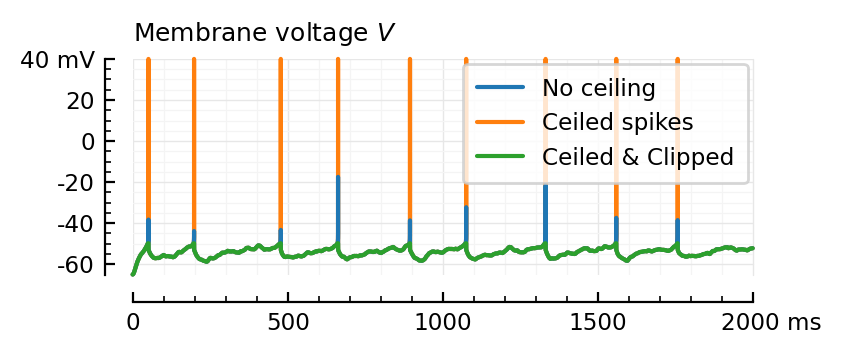

In [81]:
fig, ax = plt.subplots(figsize=(4, 1.4))
for (V, label, zorder) in Vs
    plotsig(V, [0, 2000], ms; label, zorder, yunit=:mV)
end
hylabel(ax, L"Membrane voltage $V$")
legend(ax);

## STAs

In [52]:
exc_input_1 = highest_firing(excitatory_inputs(sim))[1]

SpikeTrain(58522 spikes, 97.54 Hz, [0.004668, 0.01482, 0.04501, 0.04727, 0.05836, 0.07584, 0.0927, 0.1063, 0.1094, 0.1099  …  599.9, 600, 600, 600, 600, 600, 600, 600, 600, 600])

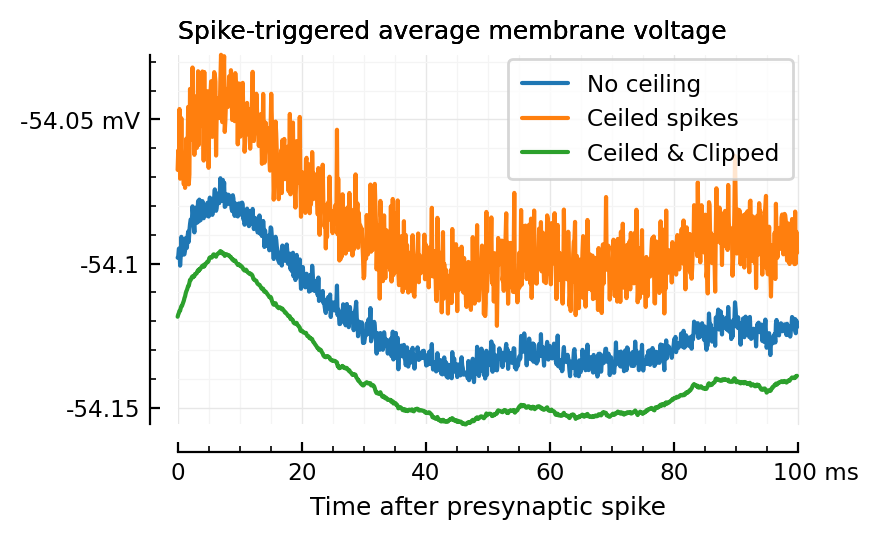

In [109]:
fig, ax = plt.subplots()
# set(ax, ylim=[-54.1601, -54.02])  # grr
for (V, label, zorder) in Vs
    STA = calc_STA(V, exc_input_1.times)
    plotSTA(STA; label, nbins_y=4)
end
plt.legend();

Interesting! They have diff base heights (very convenient for plotting on same ax, here).

Ok, it makes sense. They're averages: each sample dragged down or up.

## ROCs